# <span style='color:blue'>   TP 2 : k-plus proches voisins, LDA, régression logistique <img src="https://tinyurl.com/2p8rsven" width="80" height="80" style="float:right">


## <span style='color:red'>  Import des modules </span>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from collections import Counter 

# Import the functions of the tpp_knn_source file
from tp_knn_source import *


## <span style='color:red'>  Rappels de classification </span>

### <span style='color:green'>  - Génération artificielle de données </span>

- #### Les Fonctions :"rand_bi_gauss", "rand_tri_gauss", "rand_clown" renvoient des données distribuées selon des lois normales avec des paramètres définis. La fonction "rand_checker" renvoie des données d'un 'noisy checker'

In [2]:
# Données :  rand_bi_gauss 
X_bigauss, Y_bigauss = rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

# Données :  rand_tri_gauss
X_trigauss, Y_trigauss = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1], mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9], sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

# Données :  rand_clown
X_clown, Y_clown = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)

# Données :  rand_checkers
X_checkers, Y_checkers = rand_checkers(n1=150, n2=150, sigma=0.1)

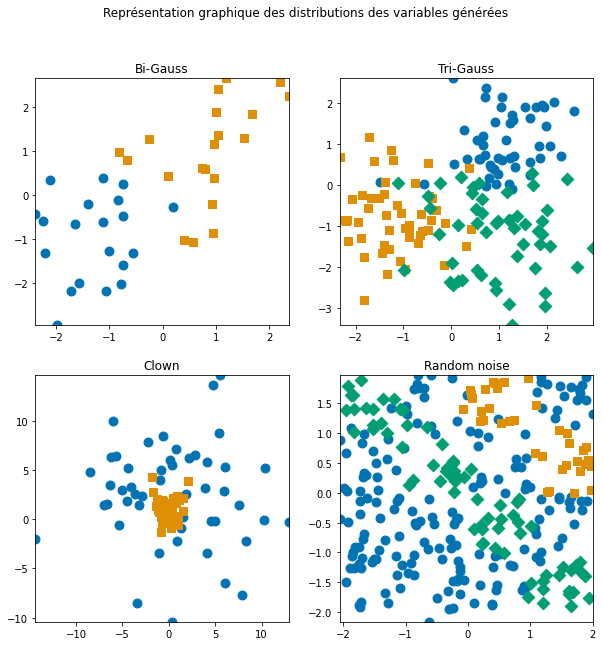

In [3]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
fig.suptitle("Représentation graphique des distributions des variables générées")

plt.subplot(221, title = "Bi-Gauss")
plot_2d(X_bigauss, Y_bigauss)   

plt.subplot(222, title = "Tri-Gauss")
plot_2d(X_trigauss, Y_trigauss)   

plt.subplot(223, title = "Clown")
plot_2d(X_clown, Y_clown)

plt.subplot(224, title = "Random noise")
plot_2d(X_checkers, Y_checkers)

## <span style='color:red'>  k-Nearest Neighbors </span>

### <span style='color:green'>  - Approche intuitive </span>

#### Question 3

- Une version adaptée de cette méthode pour la regression serait d'utiliser la moyenne, i.e. affecter à chaque point la moyenne de ses voisins.

### <span style='color:green'>  - Approche formelle </span>

#### Question 4 - Définir la classe KNNClassifier & comparaison avec KNeighborsClassifier

- Définir la classe KNNClassifier

In [4]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
    # Complete the method
        self.k = n_neighbors

    def fit(self, X_train, y_train):
    # Complete the method
        self.X = X_train
        self.Y = y_train
        return self
        
    def predict(self, X_test):
    # Complete the method
        Y =[]
        # Loop over all the points in X_test
        for x in X_test : 
            
            # Get the distance matrix between the point and all points of the Train Set
            distance = pairwise_distances(x.reshape(1,-1), self.X)
            
            # Create a dict where each distance is linked to its label
            dict1 = {dist : lab for dist, lab in zip(distance[0], self.Y)}
            
            # Sort the dictionary
            dict2 = {k : v for k,v in sorted(dict1.items(), key = lambda x: x[0])}
            
            # Get the k first entries of the dictionary. 
            ## PS. If two points have the same distance, we choose the one with the 'lowest' label by default
            dict3 = {k: dict2[k] for k in sorted(dict2.keys())[:self.k]}
            
            # Appoint the most common label to the point's predicted label
            ## Checking if there aren't as many labels in one class or another : 
            """if self.k%2 == 0 & Counter(dict3.values()).most_common(2)[0][1] == Counter(dict3.values()).most_common(2)[1][1] :
                # If so, we choose by default the one with the 'lowest' label.
                value, count = Counter(dict3.values()).most_common(1)[0]
            else :"""
            value, count = Counter(dict3.values()).most_common(1)[0]
            Y.append(value)

        return Y

    def score(self, X_test, Y_test):
        # Evaluate the score of the classifier
        return (self.predict(X_test) == Y_test).mean()

- Compasaion avec le KNeighborsClassifier

In [5]:
# Recreate the data
X_bigauss, Y_bigauss = rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[1.9, 1.9], sigmas2=[1.9, 1.9])

# Splitting the data into a Train & Test set (Train = indices pairs, Test = indices impairs)
X_bigauss_pair = X_bigauss[::2]
X_bigauss_impair = X_bigauss[1::2]
Y_bigauss_pair = Y_bigauss[::2]
Y_bigauss_impair = Y_bigauss[1::2]

###################
## KNNClassifier ##
###################

# Instantiate the classifier
clf1 = KNNClassifier(n_neighbors=3)

# Train the classifier
clf1.fit(X_bigauss_pair, Y_bigauss_pair)

# Predict on X_bigauss_test
Y_pred1 = clf1.predict(X_bigauss_impair)

# Score
score1 = clf1.score(X_bigauss_impair, Y_bigauss_impair)

##########################
## KNeighborsClassifier ##
##########################

# Instantiate the classifier
clf2 = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
clf2.fit(X_bigauss_pair, Y_bigauss_pair)

# Predict on X_bigauss_test
Y_pred2 = clf2.predict(X_bigauss_impair)

# Score
score2 = clf2.score(X_bigauss_impair, Y_bigauss_impair)

#############
## Results ##
#############

print("Le score de :\n\
    - KNNClassifier (codé) : {}%\n\
    - KNeighborsClassifier : {}%"\
        .format(score1*100, score2*100))

Le score de :
    - KNNClassifier (codé) : 75.0%
    - KNeighborsClassifier : 75.0%


#### Question 5

In [6]:
# On définit une fonction qui prend en argument les données X et Y, entraine un KNN dessus (k = 5),  et trace la frontière de décision
 
def disp_front(X, Y, k=5):
    
    X_train, X_test, Y_Train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state=42)
    knn = KNeighborsClassifier(k, p=2)
    knn.fit(X_train, Y_Train)
    #knn.fit(X, Y)

    def f(x):
        return knn.predict(x.reshape(1,-1))

    frontiere_new(f, X, Y, w=None, step=20, alpha_choice=1, colorbar=True, samples=True)
    
    return

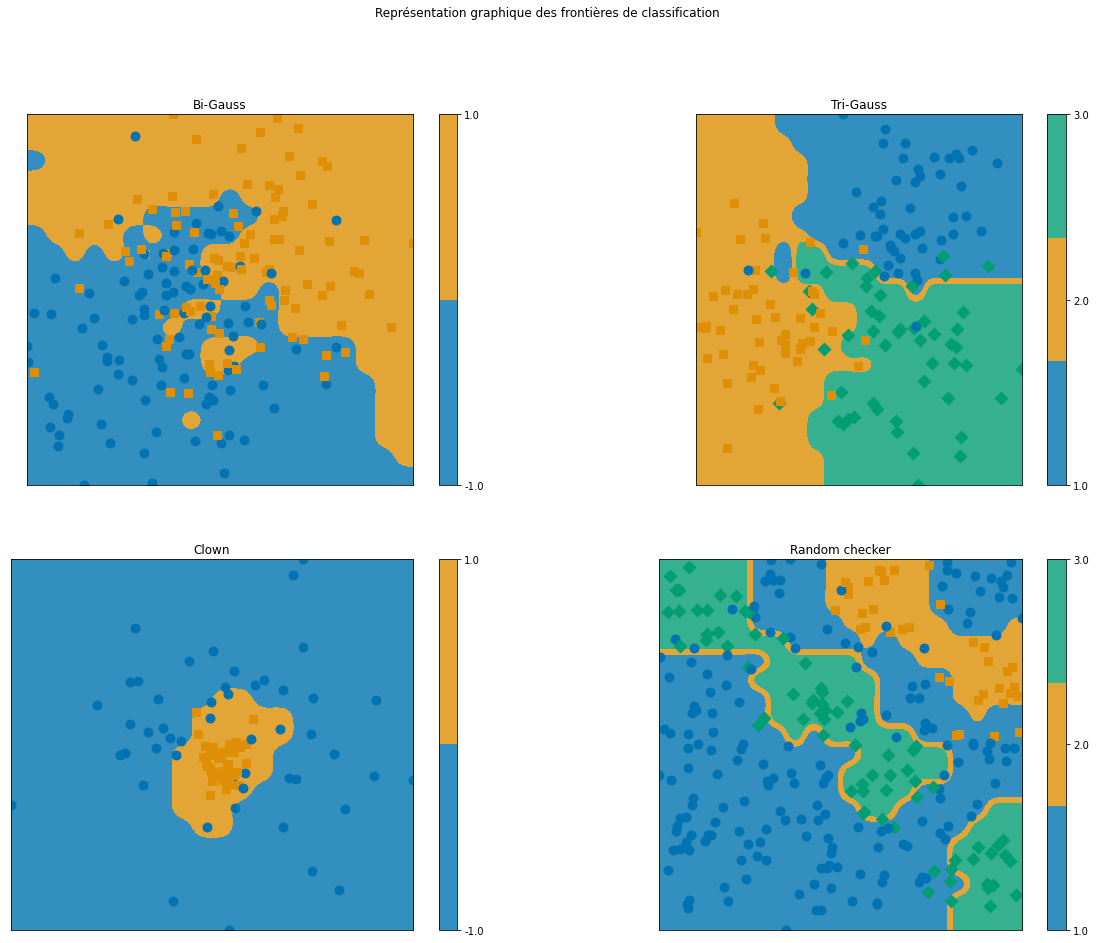

In [7]:
fig, ax = plt.subplots(2,2, figsize = (20,15))
fig.suptitle("Représentation graphique des frontières de classification")

plt.subplot(221, title = "Bi-Gauss")
disp_front(X_bigauss, Y_bigauss)

plt.subplot(222, title = "Tri-Gauss")
disp_front(X_trigauss, Y_trigauss)

plt.subplot(223, title = "Clown")
disp_front(X_clown, Y_clown)

plt.subplot(224, title = "Random checker")
disp_front(X_checkers, Y_checkers)

#### Question 6

In [8]:
X_trigauss_pair = X_trigauss[::2]
Y_trigauss_pair = Y_trigauss[::2]

In [9]:
# On définit une fonction qui prend en argument le K (n. of neighbors), instantie un KNN, fit & predict sur les données trigauss paires, et trace la frontière
 
def display(k=1):
    knn = KNeighborsClassifier(k, p=2)
    knn.fit(X_trigauss_pair, Y_trigauss_pair)

    def f(x):
        return knn.predict(x.reshape(1,-1))

    frontiere_new(f, X_trigauss_pair, Y_trigauss_pair, w=None, step=20, alpha_choice=1, colorbar=True, samples=True)
    return

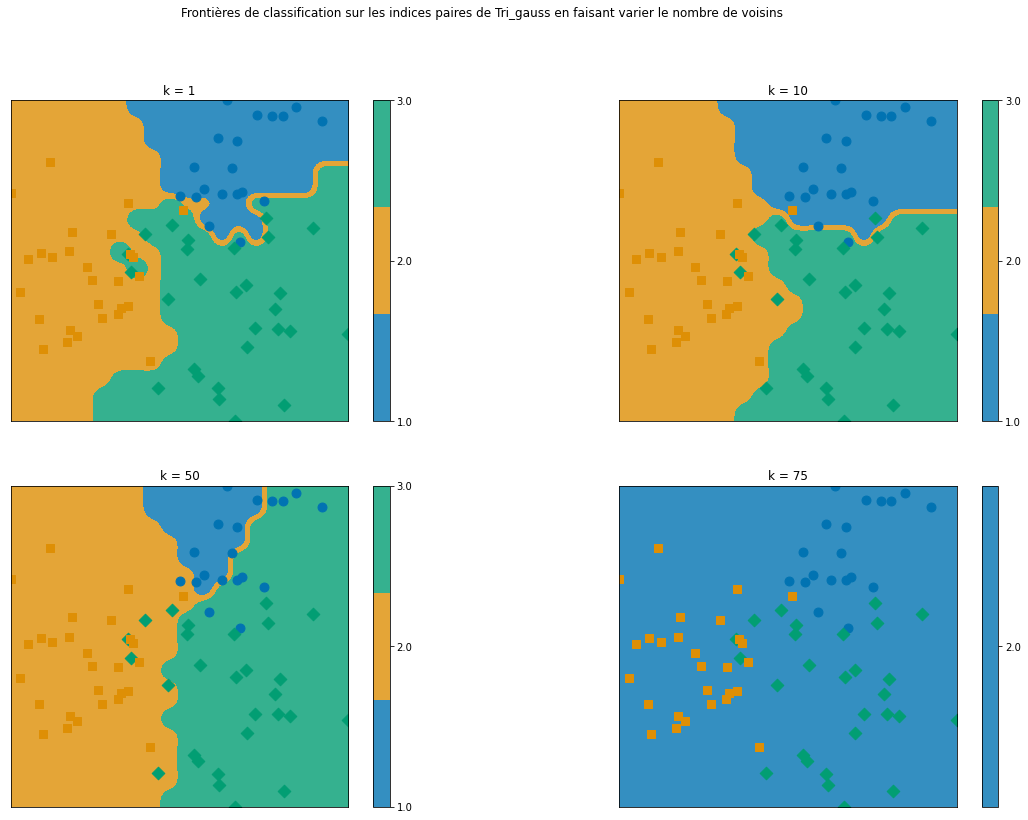

In [10]:
fig, ax = plt.subplots(2,2, figsize = (20,13))
fig.suptitle("Frontières de classification sur les indices paires de Tri_gauss en faisant varier le nombre de voisins")

plt.subplot(221, title = "k = 1")
display()

plt.subplot(222, title = "k = 10")
display(10)

plt.subplot(223, title = "k = 50")
display(50)

plt.subplot(224, title = "k = 75")
display(75)

- La frontière est complexe dans le cas où (n_neighbors = 1); car chaque point est affecté à son voisin, ce qui peut donner une frontière de décision complexe --> Overfitting the data.
- Dans le cas où (n_neighbors = n), la frontière est plus simple; car quasi toutes les valeurs sont affectées à la même classe --> Underfitting the data.

#### Question 7

In [11]:
# On définit une fonction qui pondère les poids des voisins selon une fonction définie (sur les indices paires jeu de donné #2 - Trigauss)

def add_weight(i):

    def _weight_func(dist):
        # Weight function to replace lambda d: exp(-(d**2)/h)
        h = 10**(i)
        return np.exp(-(dist**2)/h)

    knn = KNeighborsClassifier(n_neighbors = 7, weights=_weight_func, p=2)
    knn.fit(X_trigauss_pair, Y_trigauss_pair)

    def f(x):
        return knn.predict(x.reshape(1,-1))

    frontiere_new(f, X_trigauss_pair, Y_trigauss_pair, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)
    return

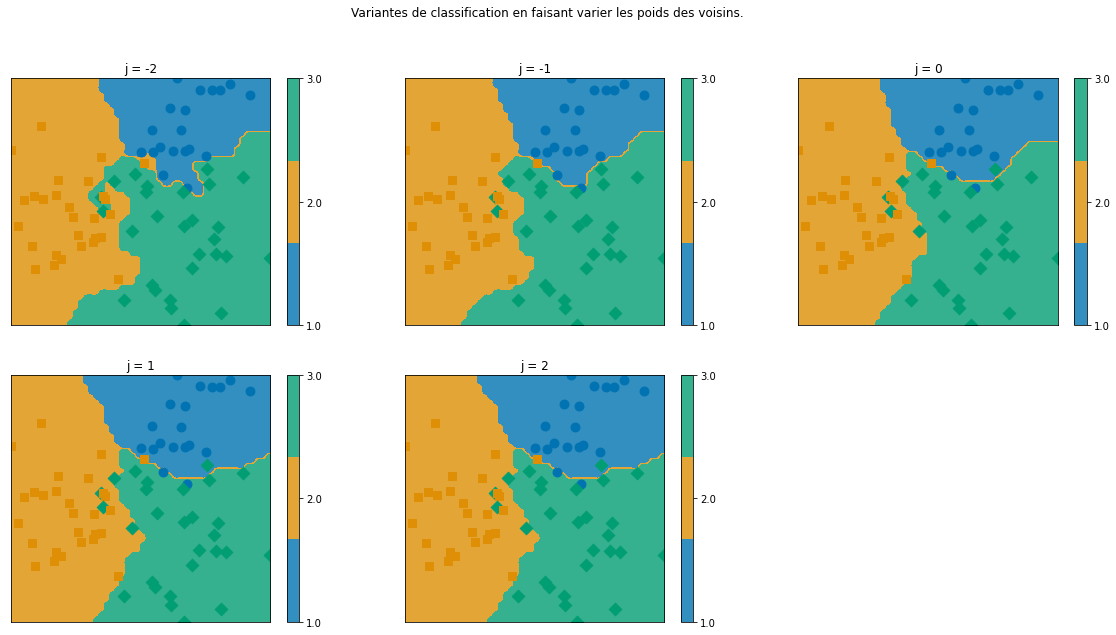

In [12]:
fig, ax = plt.subplots(1,5, figsize = (20,10))
fig.suptitle("Variantes de classification en faisant varier les poids des voisins.")

plt.subplot(231, title = "j = -2")
add_weight(-2)

plt.subplot(232, title = "j = -1")
add_weight(-1)

plt.subplot(233, title = "j = 0")
add_weight(0)

plt.subplot(234, title = "j = 1")
add_weight(1)

plt.subplot(235, title = "j = 2")
add_weight(2)



#### Question 8 - Taux d'erreur

In [13]:
X_trigauss_impair = X_trigauss[1::2]
Y_trigauss_impair = Y_trigauss[1::2]

knn = KNeighborsClassifier(n_neighbors = 1, p=2)
knn.fit(X_trigauss_pair, Y_trigauss_pair)
y_trigauss_impair_predict = knn.predict(X_trigauss_impair)
score = knn.score(X_trigauss_impair, Y_trigauss_impair)
print("Erreur: {} %".format(np.round(100-score*100,2)))

Erreur: 16.0 %


#### Question 9 - Tracer le taux d'erreur en fonction de k

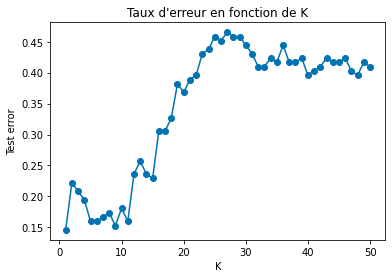

In [14]:
# Diviser le jeu de données #4 en indices paires et impaires

X_checkers_pair = X_checkers[::2]
Y_checkers_pair = Y_checkers[::2]

X_checkers_impair = X_checkers[1::2]
Y_checkers_impair = Y_checkers[1::2]

#plot_2d(X_checkers_pair, Y_checkers_pair)

k_range = np.arange(1,51)
err = ErrorCurve(k_range=k_range)
err.fit_curve(X_checkers_pair, Y_checkers_pair, X_checkers_impair, Y_checkers_impair)
err.plot()
plt.title("Taux d'erreur en fonction de K");

#### Question 10

In [15]:
# On définit une fonction qui prend en argument N : nombre de points , et qui construit la courbe d'erreur en fonction du nombre de voisin.score2

def plotk(N):

    X_checkers_train, Y_checkers_train = rand_checkers(n1=N, n2=N, sigma=0.1)
    X_checkers_test, Y_checkers_test = rand_checkers(n1=N, n2=N, sigma=0.1)
    k_range = np.arange(1,51)
    err = ErrorCurve(k_range=k_range)
    err.fit_curve(X_checkers_train, Y_checkers_train, X_checkers_test, Y_checkers_test)
    err.plot(marker='.')
    return

Text(0.5, 1.0, 'ZZZ')

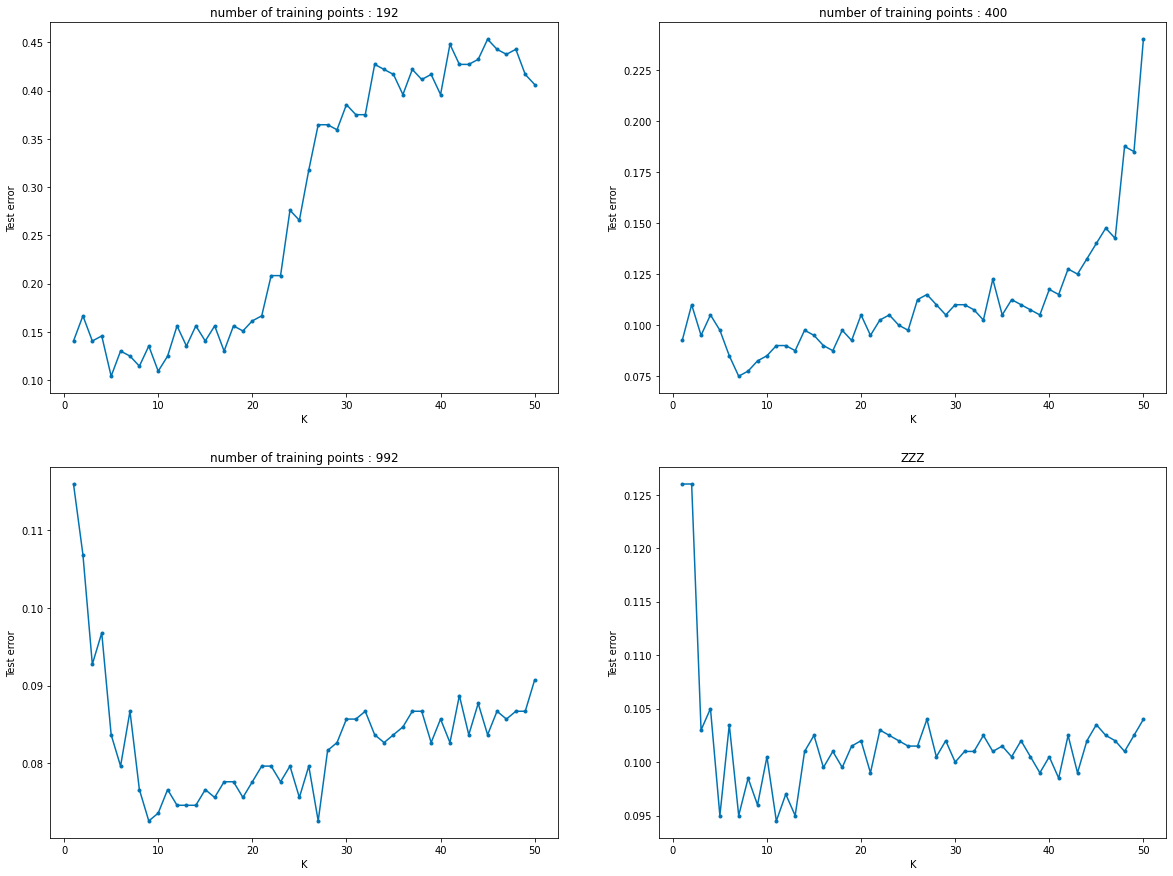

In [16]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

# Pour N=100
plt.subplot(221)
plotk(100)

# Pour N=200
plt.subplot(222)
plotk(200)

# Pour N=500
plt.subplot(223)
plotk(500)

# Pour N=1000
plt.subplot(224)
plotk(1000)

plt.title("ZZZ")

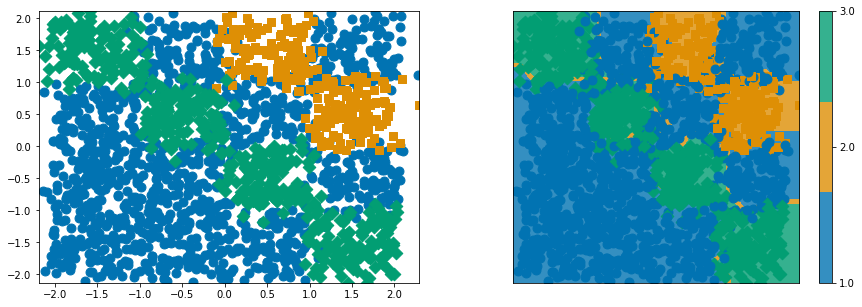

In [17]:
# Données et régles de classificaiton pour N = 1000
 
N=1000

X_checkers_train, Y_checkers_train = rand_checkers(n1=N, n2=N, sigma=0.1)
X_checkers_test, Y_checkers_test = rand_checkers(n1=N, n2=N, sigma=0.1)

plt.subplots(1,2, figsize=(15,5))
plt.subplot(121)
plot_2d(X_checkers_train, Y_checkers_train)

plt.subplot(122)
disp_front(X_checkers_train, Y_checkers_train)


#### Question 11

On remarque qu'avec la décroissance de la taille de échantillon, le temps de calcul augmente aussi. Ceci pose un problème de passage à l'échelle pour cet algorithme.
Cependant, il reste simple à interpréter et avec une fonction de display, on arrive toujours à interpreter ce que fait l'algorithme

#### Question 12

In [18]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()


- Description des données

- Affichage d'un exemple

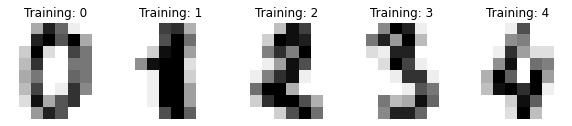

In [19]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

- Histogramme des classes

In [20]:
px.histogram(digits.target)

- Modèle de classification sur les données

In [21]:
# Creation du train & test set

X = digits.data
Y = digits.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

knn = KNeighborsClassifier(n_neighbors = 30, p=2)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
erreur = (Y_test != Y_pred).mean()
print("Erreur de classification: {} %".format(np.round(erreur*100,2)))

Erreur de classification: 6.56 %


#### Question 13 - Confusion Matrix

Taille du test set : (899,) - Somme des valeurs de la Confusion Matrix : 899


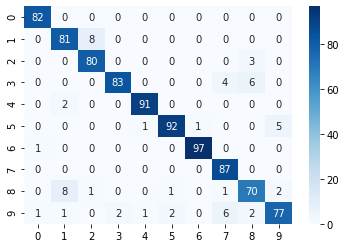

In [22]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm,annot = True, cmap=plt.cm.Blues)
print("Taille du test set : {} - Somme des valeurs de la Confusion Matrix : {}".format(Y_test.shape, cm.sum()))

#### Question 14 - Méthode de choix de k (cross-val)

Une méthode pour choisir le k optimal est la Cross Validation, où les données sont subdivisées en train, test & validation sets, où le modèle est entrainé sur le trian set, le paramètre k est retrouvé par validation croisée en K-folds, et le modèle évalué sur le validation set

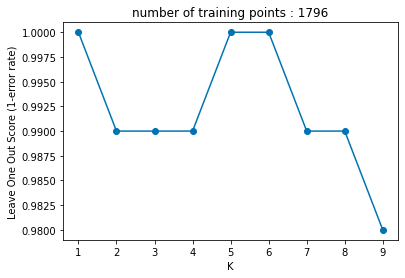

In [23]:
k_range = np.arange(1,10)
loo = LOOCurve(k_range = k_range)
loo.fit_curve(X,Y, n_iter=100)
loo.plot()

Nous remarquons que le meilleur score est atteint pour des valeurs de k dans {1, 5, 6}, ensuite un deuxième palier dans {2,3,4,7,8}.
Au délà de ce seuil, l'augmentation du nombre de voisins considéré dégrade le score du modèle.

## <span style='color:red'>  Linear Discriminant Analysis </span>

### <span style='color:green'>  - Aspect théorique </span>

#### Question 15 - Formule des probabilités à postériori en utilisant Bayes

##### a.

On rappelle que :
$$\mathbb{P} \{ A | B \} 
= 
\frac 
{   \mathbb{P} \{  B | A  \}
    \mathbb{P} \{ A \}} 
{\mathbb{P} \{ B  \}}

En l'appliquant ici : 

$$\begin{align*}
\mathbb{P} \{ Y = +1 | X = x \}
&= 
\frac 
{   \mathbb{P} \{  X = x | Y = +1  \}
    \mathbb{P} \{ Y = +1 \}} 
{\mathbb{P} \{ X = x  \}}
\\
\\
\mathbb{P} \{ Y = +1 | X = x \} &= 
\frac 
{   \mathbb{P} \{  X = x | Y = +1  \}. \mathbb{P} \{ Y = +1 \}} 
{\mathbb{P} \{  X = x | Y = +1  \}.\mathbb{P} \{ Y = +1  \} + \mathbb{P} \{ X = x | Y = -1   \}.\mathbb{P} \{ Y = -1  \} }

\\
\\
\end{align*}
\\
\mathbin{\textcolor{red}{\mathbb{P} \{ Y = +1 | X = x \} = \frac {\pi_+ f_+} {f_+. \pi_+ + f_-.(1-\pi_+) }}}

$$


D'autre part : 

$$\begin{align*}
\mathbb{P} \{ Y = -1 | X = x \}
&= 
\frac 
{   \mathbb{P} \{  X = x | Y = -1  \}
    \mathbb{P} \{ Y = -1 \}} 
{\mathbb{P} \{ X = x  \}}
\\
\\
\mathbb{P} \{ Y = -1 | X = x \} &= 
\frac 
{   \mathbb{P} \{  X = x | Y = -1  \}. \mathbb{P} \{ Y = -1 \}} 
{\mathbb{P} \{  X = x | Y = +1  \}.\mathbb{P} \{ Y = +1  \} + \mathbb{P} \{ X = x | Y = -1   \}.\mathbb{P} \{ Y = -1  \} }

\\
\\
\end{align*}
\\
\mathbin{\textcolor{red}{\mathbb{P} \{ Y = -1 | X = x \} = \frac {(1 - \pi_-)  f_-} {f_+. \pi_+ + f_-.(1-\pi_+) }}}

$$


#### Question 16 - Expression du log-ratio des deux classes

Par résultat direct de la question précédente :
$$
log(
    \frac
    {\mathbb{P} \{ Y = +1 | X = x \}}
    {\mathbb{P} \{ Y = -1 | X = x \}}
    )
=

log(
    \frac 
    {f_+.\pi_+} 
    {f_-.(1 - \pi_+ )}
)

On rappelle que :
$$
f(x)
=
\frac 
{1} 
{(2\pi)^{p/2} \sqrt{det(\Sigma)}}
exp\{
    -\frac{1}{2}
    (x - \mu)^T
    \Sigma ^{-1}
    (x - \mu)
    \}
    



Et que :

$$
f_+
=
\frac 
{1} 
{(2\pi)^{p/2} \sqrt{det(\Sigma)}}
exp\{
    -\frac{1}{2}
    (x - \mu_+)^T
    \Sigma ^{-1}
    (x - \mu_+)
    \}
\ \ \ \ \ \ et \ \ \ \ \ \ 
f_-
=
\frac 
{1} 
{(2\pi)^{p/2} \sqrt{det(\Sigma)}}
exp\{
    -\frac{1}{2}
    (x - \mu_-)^T
    \Sigma ^{-1}
    (x - \mu_-)
    \}
$$



Donc :

$$
\frac {f_+}{f_-}
=
\frac 
{
    exp\{
    -\frac{1}{2}
    (x - \mu_+)^T
    \Sigma ^{-1}
    (x - \mu_+)
    \}
} 
{exp\{
    -\frac{1}{2}
    (x - \mu_-)^T
    \Sigma ^{-1}
    (x - \mu_-)
    \}
    }
$$


Donc :


$$\begin{align*}

log(
    \frac 
    {f_+.\pi_+} 
    {f_-.(1 - \pi_+ )}
)

&=
log
(
\frac 
{   (\pi_+)
    exp\{
    -\frac{1}{2}
    (x - \mu_+)^T
    \Sigma ^{-1}
    (x - \mu_+)
    \}
} 
    
{   (1 - \pi_+ )
    exp\{
    -\frac{1}{2}
    (x - \mu_-)^T
    \Sigma ^{-1}
    (x - \mu_-)
    \}
    }
)
\\ 
\\ 
\\
log(
    \frac 
    {f_+.\pi_+} 
    {f_-.(1 - \pi_+ )}
)

&=
log
(
\frac 
{   (\pi_+)
} 
    
{   (1 - \pi_+ )
}
+ 

    (-\frac{1}{2}
    (x - \mu_+)^T
    \Sigma ^{-1}
    (x - \mu_+)
    )
- 

    (-\frac{1}{2}
    (x - \mu_-)^T
    \Sigma ^{-1}
    (x - \mu_-))
\\
\\
\\
log(
    \frac 
    {f_+.\pi_+} 
    {f_-.(1 - \pi_+ )}
)

&=
log
(
\frac 
{   (\pi_+)
} 
    
{   (1 - \pi_+ )
}
- 

    (\frac{1}{2}
    (x - \mu_+)^T
    \Sigma ^{-1}
    (x - \mu_+)
    )
+

    (\frac{1}{2}
    (x - \mu_-)^T
    \Sigma ^{-1}
    (x - \mu_-))
\\
\\
\\

log(
    \frac 
    {f_+.\pi_+} 
    {f_-.(1 - \pi_+ )}
)

&=
log
(
\frac 
{   (\pi_+)
} 
    
{   (1 - \pi_+ )
}
-   
    \frac{1}{2}
    (
    (x^T \Sigma^{-1} x) -
    (x^T \Sigma^{-1} \mu_+) - 
    (\mu_+^T \Sigma^{-1} x) + 
    (\mu_+^T \Sigma^{-1} \mu_+)
    )
+
    \frac{1}{2}
    (
    (x^T \Sigma^{-1} x) -
    (x^T \Sigma^{-1} \mu_-) - 
    (\mu_-^T \Sigma^{-1} x) + 
    (\mu_-^T \Sigma^{-1} \mu_-)
    )
\\
\\
\\

log(
    \frac 
    {f_+.\pi_+} 
    {f_-.(1 - \pi_+ )}
)

&=
log
(
\frac 
{   (\pi_+)
} 
    
{   (1 - \pi_+ )
}
-   
    [\frac{1}{2} (x^T \Sigma^{-1} x) -
    (x^T \Sigma^{-1} \mu_+) - 
    \frac{1}{2} (\mu_+^T \Sigma^{-1} \mu_+)
    ]
+
    [\frac{1}{2} (x^T \Sigma^{-1} x) -
    (x^T \Sigma^{-1} \mu_-) - 
    \frac{1}{2} (\mu_-^T \Sigma^{-1} \mu_-)
    ]

\end{align*}$$



$$ \mathbin{\textcolor{red}{
     
log(
    \frac
    {\mathbb{P} \{ Y = +1 | X = x \}}
    {\mathbb{P} \{ Y = -1 | X = x \}}
    )

=
log
(
\frac 
{   (\pi_+)
} 
    
{   (1 - \pi_+ )
}
+   
    [x^T \Sigma^{-1} (\mu_+ - \mu_-)] - 
    (\frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+) +
    (\frac{1}{2} \mu_-^T \Sigma^{-1} \mu_-))}}
$$
    



#### Question 17 - Justification  du choix du classifier

Pour notre stratégie de classification, on prend le Classifier suivant

$$\begin{align*}
Classifier &=
    \begin{cases}
      +1 & \text{if   } \mathbb{P} \{ Y = +1 | X = x \} > \mathbb{P} \{ Y = -1 | X = x \}\\
      -1 & \text{otherwise}\\
    \end{cases}       

\\
\\
Classifier &=
    \begin{cases}
      +1 & \text{if   } \frac {\mathbb{P} \{ Y = +1 | X = x \}} {\mathbb{P} \{ Y = -1 | X = x \}} > 1 \\
      -1 & \text{otherwise}\\
    \end{cases}  

\\
\\
Classifier &=
    \begin{cases}
      +1 & \text{if   } log{(\frac {\mathbb{P} \{ Y = +1 | X = x \}} {\mathbb{P} \{ Y = -1 | X = x \}})} > 0 \\
      -1 & \text{otherwise}\\
    \end{cases}  

    \end{align*}$$     

Donc 

$$\begin{align*}
     
log(
    \frac
    {\mathbb{P} \{ Y = +1 | X = x \}}
    {\mathbb{P} \{ Y = -1 | X = x \}}
    )
> 0
&\Leftrightarrow

log
(
\frac 
{   (\pi_+)
} 
    
{   (1 - \pi_+ )
}
+   
    [x^T \Sigma^{-1} (\mu_+ - \mu_-)] - 
    (\frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+) +
    (\frac{1}{2} \mu_-^T \Sigma^{-1} \mu_-)) >0

\\
\\

log(
    \frac
    {\mathbb{P} \{ Y = +1 | X = x \}}
    {\mathbb{P} \{ Y = -1 | X = x \}}
    )
> 0
&\Leftrightarrow

[x^T \Sigma^{-1} (\mu_+ - \mu_-)] >

(\frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+) -
(\frac{1}{2} \mu_-^T \Sigma^{-1} \mu_-) - 
log(\frac {(\pi_+)} {(1 - \pi_+ )}
)
\end{align*}$$
    



Enfin 
$$ \mathbin{\textcolor{red}{


Classifier =
    \begin{cases}
      +1 & \text{if   } 
      
      x^T \Sigma^{-1} (\mu_+ - \mu_-) >

    (\frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+) -
    (\frac{1}{2} \mu_-^T \Sigma^{-1} \mu_-) +
    log(1 - \frac {m} {n} ) - 
    log(\frac {m} {n} )
      
      \\
      
      
      -1 & \text{otherwise}\\
    \end{cases} 
}}
$$
    



### <span style='color:green'>  - Mise en oeuvre </span>

#### Question 18 - Définition du LDAClassifier

In [24]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade LDA classifier class """
    def __init__(self):
        # Complete the method
        return
        

    def fit(self, X_train, y_train):
        # Complete the method
        self.X = X_train
        self.Y = y_train

        # Dimensions
        n = len(self.Y)
        m = Counter(self.Y)[1]

        # Pi^+
        pi_plus = m/n
        
        t = tuple(map(tuple, self.X))
        tt = dict(zip(t,self.Y))
        pos = {k:v for k,v in tt.items() if v==1}
        neg = {k:v for k,v in tt.items() if v!=1}
        ppos = list(pos.keys())
        ppos = np.array([list(x) for x in ppos])
        pneg = list(neg.keys())
        pneg = np.array([list(x) for x in pneg])

        # Mu^+
        self.mu_pos = sum(ppos)/len(ppos)

        # Mu^-
        self.mu_neg = sum(pneg)/len(pneg)

        # Sig^+
        σ_pos = (ppos - self.mu_pos).T @ (ppos - self.mu_pos) / (m-1)

        # Sig^-        
        σ_neg = (pneg - self.mu_neg).T @ (pneg - self.mu_neg) / (n-m-1)

        # Sig
        self.σ = ((m-1) * σ_pos + (n-m-1) * σ_neg) / (n-2)
        self.σ_inv = np.linalg.inv(self.σ)
        
        self.threshold = ((self.mu_pos.T @ self.σ_inv ) @ self.mu_pos / 2) + ((self.mu_neg.T @ self.σ_inv ) @ self.mu_neg / 2) + np.log(1-(m / n)) - np.log(m+n)

        return self
        
    def predict(self, X_test):
    # Complete the method
        Y = []
        for x in X_test:
            
            if (x @ (self.σ_inv @ (self.mu_pos - self.mu_neg))) > self.threshold : 
                Y.append(1)
            else : 
                Y.append(-1)

        return Y

    def score(self, X_test, Y_test):
        # Evaluate the score of the classifier
        return (self.predict(X_test) == Y_test).mean()

#### Question 19 - Comparaison entre LDAClassifier et LinearDiscriminantAnalysis

In [25]:
# Recreate the data
X_bigauss, Y_bigauss = rand_bi_gauss(n1=500, n2=50, mu1=[1, 1], mu2=[-1, -1], sigmas1=[.9, .9], sigmas2=[.9, .9])

# Splitting the data into a Train & Test set (Train = indices pairs, Test = indices impairs)
X_train, X_test, Y_train, Y_test = train_test_split(X_bigauss, Y_bigauss, test_size = 0.75, random_state = 42)

###################
## LDAClassifier ##
###################

# Instantiate the classifier
lda = LDAClassifier()

# Train the classifier
lda.fit(X_train, Y_train)

# Predict on X_bigauss_test
Y_pred1 = lda.predict(X_test)

# Score
score1 = lda.score(X_test, Y_test)

################################
## LinearDiscriminantAnalysis ##
################################

# Instantiate the classifier
clf2 = LinearDiscriminantAnalysis()

# Train the classifier
clf2.fit(X_train, Y_train)

# Predict on X_bigauss_test
Y_pred2 = clf2.predict(X_test)

# Score
score2 = clf2.score(X_test, Y_test)

#############
## Results ##
#############

print("Le score de :\n\
    - LDAClassifier (codé)       : {}%\n\
    - LinearDiscriminantAnalysis : {}%"\
        .format(np.round(score1*100,2), np.round(score2*100,2)))

print("\nLe taux d'erreur de :\n\
    - LDAClassifier (codé)       : {}%\n\
    - LinearDiscriminantAnalysis : {}%"\
        .format(np.round(100-score1*100,2), np.round(100-score2*100,2)))

same = (Y_pred1 == Y_pred2).mean()
print("\nLes prédictions des deux modèles se ressemblent à : {}%".format(np.round(same*100,2)))

Le score de :
    - LDAClassifier (codé)       : 94.67%
    - LinearDiscriminantAnalysis : 95.64%

Le taux d'erreur de :
    - LDAClassifier (codé)       : 5.33%
    - LinearDiscriminantAnalysis : 4.36%

Les prédictions des deux modèles se ressemblent à : 95.64%


- Frontières de classification

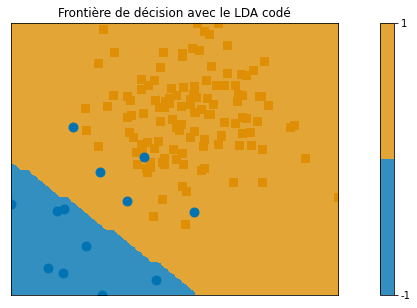

In [26]:
plt.subplots(1,1, figsize=(15,5))

def f1(x):
    return lda.predict(x.reshape(1,-1))

plt.subplot(111)
frontiere_new(f1, X_train, Y_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)
plt.title("Frontière de décision avec le LDA codé");

#### Question 20 - Visualtion des rgèles de classification du LDAClassifier

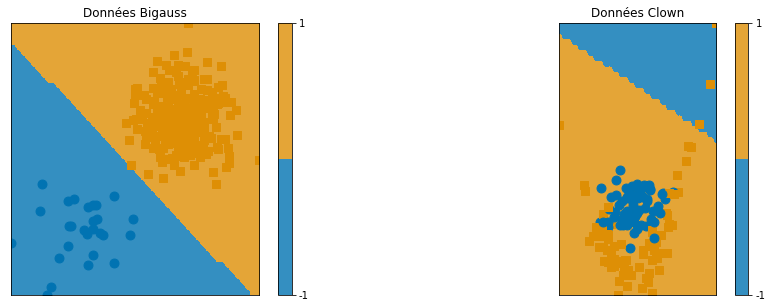

In [27]:
plt.subplots(1,2, figsize=(15,5))

##############################
## Données :  rand_bi_gauss ##
##############################

X_bigauss, Y_bigauss = rand_bi_gauss(n1=1000, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.5, 0.5], sigmas2=[0.5, 0.5])
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_bigauss, Y_bigauss, test_size = 0.75, random_state = 42)
lda1 = LDAClassifier()
lda1.fit(X_train1, Y_train1)

def f1(x):
    return lda1.predict(x.reshape(1,-1))

plt.subplot(121)
frontiere_new(f1, X_train1, Y_train1, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)
plt.title("Données Bigauss");

##########################
# Données :  rand_clown ##
##########################

X_clown, Y_clown = rand_clown(n1=100, n2=100, sigma1=.5, sigma2=.5)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_clown, Y_clown, test_size = 0.75, random_state = 42)
lda2 = LDAClassifier()
lda2.fit(X_train2, Y_train2)

def f2(x):
    return lda2.predict(x.reshape(1,-1))

plt.subplot(122)
frontiere_new(f2, X_test2, Y_test2, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)
plt.title("Données Clown");

- Dans le cas #1 (Bigaussian Data), où les données sont séparables par une frontière linéaire claire, le LDA est efficace, comme on peut le constater sur le display des frontières.  


- Dans le cas #3 (Clown Data), le classifier LDA n'est pas efficace, car par définition il retrouve des frontières linéaires, alors que le jeu de données requiert des frontières quadratiques. De ce fait, le classifier souffre d'un gros biais.

## <span style='color:red'>  Regression Logisitique </span>

### <span style='color:green'>   - Mise en oeuvre </span> </span>

#### Question 21 

In [28]:
# Recreate the data
X_bigauss, Y_bigauss = rand_bi_gauss(n1=1000, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[1.9, 1.9], sigmas2=[1.9, 1.9])

# Splitting the data into a Train & Test set
X_bigauss_train, X_bigauss_test, Y_bigauss_train, Y_bigauss_test = train_test_split(X_bigauss, Y_bigauss, test_size=0.5, random_state=42)

# Instantiate the model
lr = LogisticRegression()

# Train the model
lr.fit(X_bigauss_train, Y_bigauss_train)

# Predict Y of X_bigauss_test
Y_bigauss_pred = lr.predict(X_bigauss_test)

# Score of the model
score = lr.score(X_bigauss_test, Y_bigauss_test)
print("Score de la Régression Logistique : {}%".format(np.round(score*100,2)))


Score de la Régression Logistique : 91.64%


#### Question 22 - Interpretation des paramètres du modèle 

In [29]:
coeff = lr.coef_
intercept = lr.intercept_

print("Coeff : {}\nIntercept : {}".format(coeff, intercept))

Coeff : [[0.70216286 0.42618646]]
Intercept : [2.32971875]


Dans un modèle de Regression logistique, la variable : 
- **coef** correspond à la variable de poids attribué à chaque covariable dans la fonction de décision.
- **intercept** correspond au bias introduit dans le modèle, dans la fonction de décision.


#### Question 23 - Visualiser la frontière de décision.

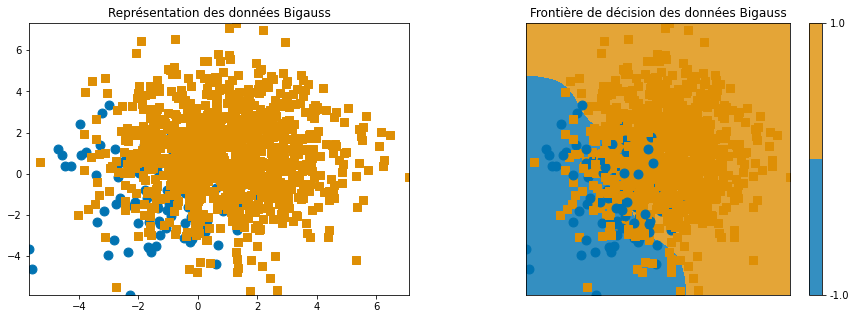

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5) )

plt.subplot(121)
plot_2d(X_bigauss, Y_bigauss)
plt.title("Représentation des données Bigauss")   

def f(x):
    return lr.predict(x.reshape(1,-1))
plt.subplot(122)
frontiere_new(f, X_bigauss, Y_bigauss, w=None, step=5, alpha_choice=1, colorbar=True, samples=True)
plt.title("Frontière de décision des données Bigauss");

#### Question 24 - Classification par Regression Logistique au dataset DIGITS

In [31]:
# Loading the data
digits = datasets.load_digits()
X = digits.data
Y = digits.target

# Splitting the data into a Train & Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Instantiate the model
lr = LogisticRegression(max_iter=10000)

# Train the model
lr.fit(X_train, Y_train)

# Predict on X_test
Y_pred = lr.predict(X_test)

# Scoring the model
score = lr.score(X_test, Y_test)
print("Taux d'erreur : {}%".format(np.round(100-score*100,2)))

Taux d'erreur : 4.0%
